## Columns to be removed from training/validation

In [1]:
disqualified_columns = ["tls_joint_isoitu_policy_crt_count", "rdap_time_from_last_change", "lex_www_flag"]

## Feature Prefix

In [2]:
prefix = "dns_"

# Specify paths and model names

In [3]:
scaler_path = 'boundaries/malware_dns_nn_scaler.joblib'
model_path = 'models/malware_dns_nn_model.keras'
validation_dataset_filename = '../testdata/validation_malware.parquet'

# Load Tensorflow and check GPU availability

In [4]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

2024-07-01 21:01:25.850858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 21:01:25.850877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 21:01:25.851589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 21:01:25.855663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 21:01:26.396997: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


2024-07-01 21:01:27.178166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-07-01 21:01:27.182631: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 6271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


# Load input datasets

In [5]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/malware_3.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
# df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df.columns:
        df.drop(column, axis=1, inplace=True)


# Preserve only columns of interest
# Filter columns
df = df.loc[:, df.columns.str.startswith(prefix) | df.columns.isin(['domain_name', 'label'])]
        
labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



df

Total samples: 947114
Benign count: 816324
Malicious count: 130790


,label,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,...,dns_soa_min_ttl,dns_domain_name_in_mx,dns_mx_avg_len,dns_mx_avg_entropy,dns_txt_avg_len,dns_txt_avg_entropy,dns_txt_external_verification_score,dns_txt_spf_exists,dns_txt_dkim_exists,dns_txt_dmarc_exists
0,benign,0.0,0,0,0,0,0,0,1,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
1,benign,0.0,0,0,0,0,0,0,1,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
2,benign,1.0,1,1,1,4,2,1,0,0,...,3600.0,False,12.0,0.204235,42.0,0.14178,1,1,0,0
3,benign,0.0,1,0,0,0,0,0,0,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
4,benign,0.0,1,0,0,0,0,0,0,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130785,malware,0.0,0,0,0,0,0,0,1,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
130786,malware,0.0,0,0,0,0,0,0,0,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
130787,malware,1.0,0,0,0,0,0,0,0,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0
130788,malware,1.0,0,0,0,0,0,0,0,0,...,-1.0,False,-1.0,-1.000000,-1.0,-1.00000,0,0,0,0


# Data preprocessing

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, scaler_path)

pd.set_option('display.max_columns', None)
features

,dns_has_dnskey,dns_A_count,dns_AAAA_count,dns_MX_count,dns_NS_count,dns_TXT_count,dns_SOA_count,dns_CNAME_count,dns_zone_level,dns_zone_digit_count,dns_zone_len,dns_zone_entropy,dns_resolved_record_types,dns_dnssec_score,dns_ttl_avg,dns_ttl_stdev,dns_ttl_low,dns_ttl_mid,dns_ttl_distinct_count,dns_soa_primary_ns_level,dns_soa_primary_ns_digit_count,dns_soa_primary_ns_len,dns_soa_primary_ns_entropy,dns_soa_email_level,dns_soa_email_digit_count,dns_soa_email_len,dns_soa_email_entropy,dns_soa_refresh,dns_soa_retry,dns_soa_expire,dns_soa_min_ttl,dns_domain_name_in_mx,dns_mx_avg_len,dns_mx_avg_entropy,dns_txt_avg_len,dns_txt_avg_entropy,dns_txt_external_verification_score,dns_txt_spf_exists,dns_txt_dkim_exists,dns_txt_dmarc_exists
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.00000,0.095652,0.563985,0.142857,0.666667,4.223520e-07,4.204264e-07,0.928571,0.5,0.375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.00000,0.095652,0.563985,0.142857,0.666667,4.223520e-07,4.204264e-07,0.928571,0.5,0.375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,1.0,0.002786,0.002786,0.004255,0.039216,0.009217,1.0,0.0,0.0,0.15625,0.069565,0.366443,0.857143,1.000000,6.708737e-06,1.531652e-06,0.571429,0.5,0.500,0.181818,0.029412,0.156627,0.813436,0.142857,0.033333,0.125984,0.781827,0.000002,8.919815e-07,0.000583,0.000002,0.0,0.144444,0.787947,0.167969,0.747081,0.004651,1.0,0.0,0.0
3,0.0,0.002786,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.069565,0.591497,0.142857,0.666667,4.023612e-05,4.023451e-05,0.928571,0.5,0.375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.002786,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.069565,0.591497,0.142857,0.666667,4.023612e-05,4.023451e-05,0.928571,0.5,0.375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947109,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.00000,0.121739,0.495437,0.142857,0.666667,1.679629e-06,1.677713e-06,0.928571,0.5,0.375,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
947110,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.017391,0.946395,0.000000,0.666667,3.259607e-09,1.330739e-09,1.000000,0.5,0.250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
947111,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.026087,1.000000,0.000000,0.666667,3.259607e-09,1.330739e-09,1.000000,0.5,0.250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
947112,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.017391,0.946395,0.000000,0.666667,3.259607e-09,1.330739e-09,1.000000,0.5,0.250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


# Train-test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Define the NN model

In [8]:

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(40,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[Precision(), Recall(), AUC()]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                1968      
                                                                 
 batch_normalization (Batch  (None, 48)                192       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                3136      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

2024-07-01 21:01:32.002982: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-07-01 21:01:32.003641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6271 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


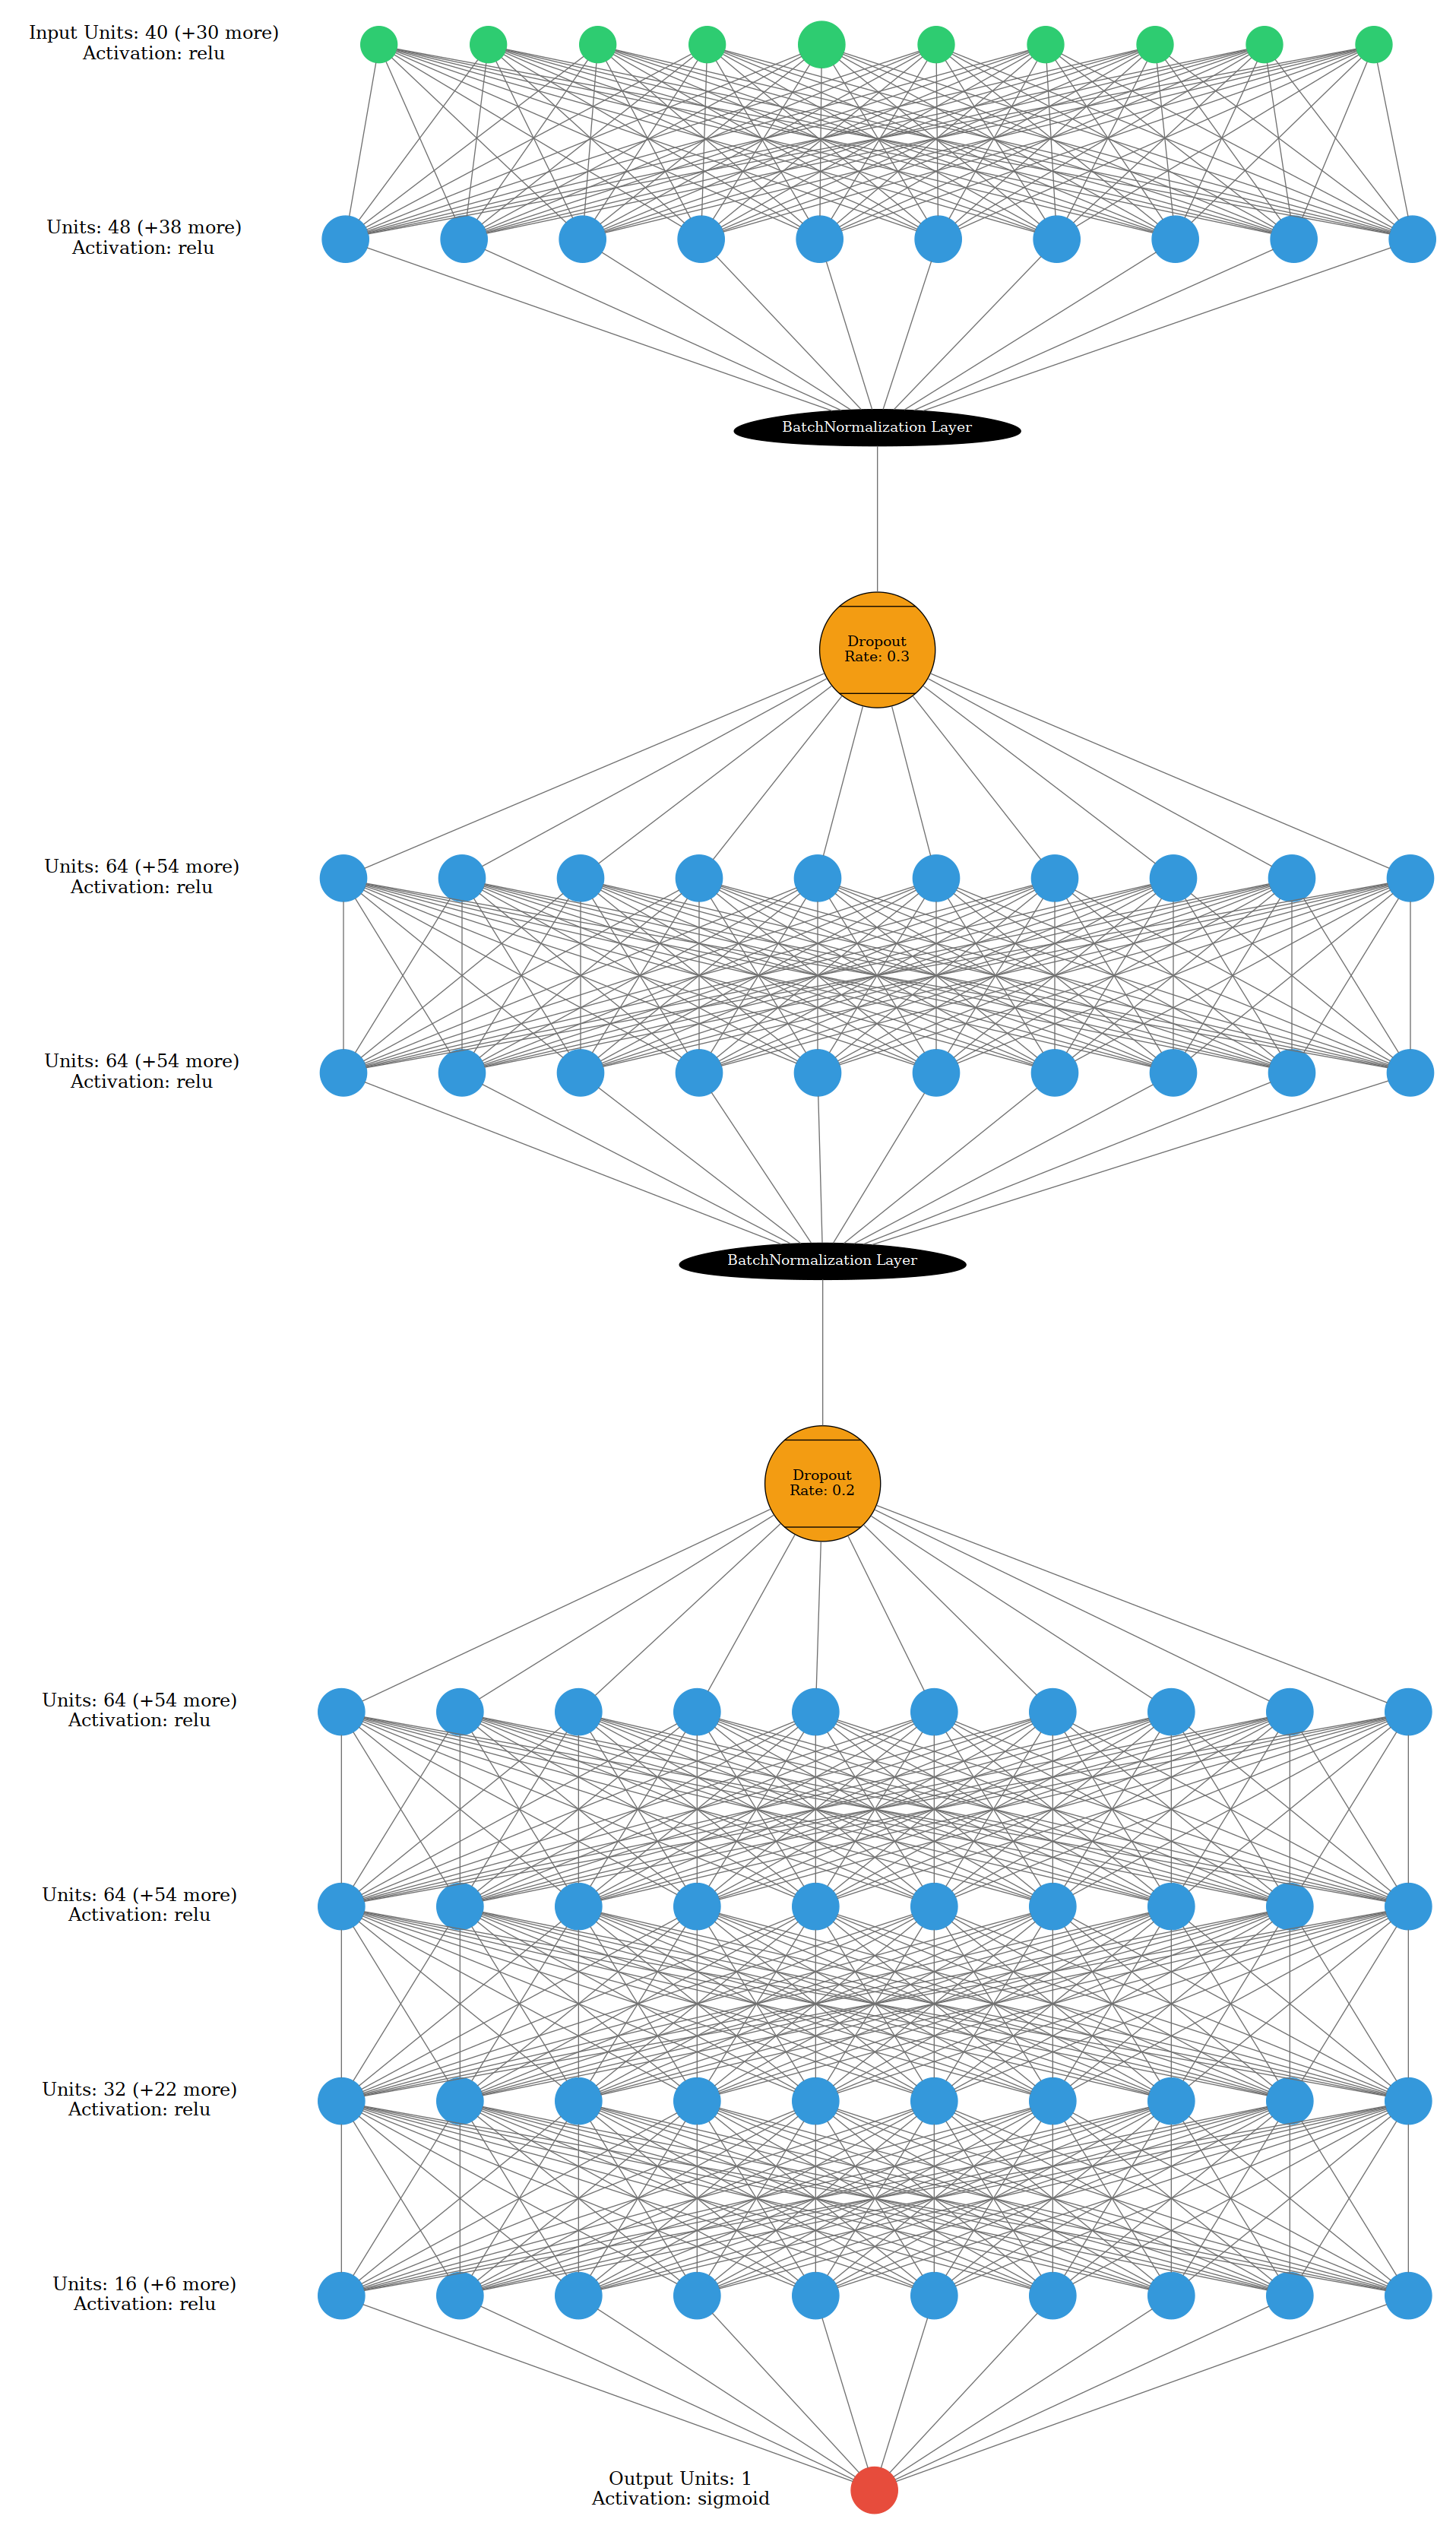

In [9]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 10,
}

from keras_visualizer import visualizer
from keras import models, layers

visualizer(model, file_format='png', settings=settings, view=True)

from IPython.display import Image
Image(filename='graph.png')

# Train the model

In [10]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Calculate class weights
class_weights = {0: 1.0, 1: 1.5} 

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=60,
    validation_data=(X_test, Y_test),  # Provide validation data
    class_weight=class_weights,  # Apply class weights here
    callbacks=[early_stopping]  # Add early stopping callback
)


Epoch 1/60


2024-07-01 21:01:34.088425: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-01 21:01:35.785054: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb609643b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 21:01:35.785076: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-01 21:01:35.789558: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 21:01:35.802122: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1719860495.867693 1398910 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1480/1480 [==============================] - 18s 9ms/step - loss: 0.3992 - precision: 0.6135 - recall: 0.3593 - auc: 0.8163 - val_loss: 0.2977 - val_precision: 0.5838 - val_recall: 0.4919 - val_auc: 0.8556
Epoch 2/60
1480/1480 [==============================] - 11s 7ms/step - loss: 0.3702 - precision: 0.6408 - recall: 0.4091 - auc: 0.8466 - val_loss: 0.2788 - val_precision: 0.6280 - val_recall: 0.4867 - val_auc: 0.8651
Epoch 3/60
1480/1480 [==============================] - 14s 9ms/step - loss: 0.3610 - precision: 0.6419 - recall: 0.4321 - auc: 0.8558 - val_loss: 0.2772 - val_precision: 0.6465 - val_recall: 0.4757 - val_auc: 0.8702
Epoch 4/60
1480/1480 [==============================] - 12s 8ms/step - loss: 0.3547 - precision: 0.6453 - recall: 0.4515 - auc: 0.8611 - val_loss: 0.2861 - val_precision: 0.6114 - val_recall: 0.5354 - val_auc: 0.8750
Epoch 5/60
1480/1480 [==============================] - 14s 9ms/step - loss: 0.3514 - precision: 0.6490 - recall: 0.4581 - auc: 0.8642 - val_lo

Epoch 39/60
1480/1480 [==============================] - 10s 7ms/step - loss: 0.3287 - precision: 0.6842 - recall: 0.4995 - auc: 0.8826 - val_loss: 0.2573 - val_precision: 0.6745 - val_recall: 0.5434 - val_auc: 0.8912
Epoch 40/60
1480/1480 [==============================] - 11s 8ms/step - loss: 0.3277 - precision: 0.6859 - recall: 0.5000 - auc: 0.8834 - val_loss: 0.2527 - val_precision: 0.7041 - val_recall: 0.5107 - val_auc: 0.8871
Epoch 41/60
1480/1480 [==============================] - 13s 9ms/step - loss: 0.3276 - precision: 0.6826 - recall: 0.5038 - auc: 0.8835 - val_loss: 0.2531 - val_precision: 0.6915 - val_recall: 0.5336 - val_auc: 0.8919
Epoch 42/60
1480/1480 [==============================] - 12s 8ms/step - loss: 0.3276 - precision: 0.6837 - recall: 0.5035 - auc: 0.8833 - val_loss: 0.2532 - val_precision: 0.6879 - val_recall: 0.5355 - val_auc: 0.8928
Epoch 43/60
1480/1480 [==============================] - 11s 7ms/step - loss: 0.3273 - precision: 0.6823 - recall: 0.5052 - auc:

# Save the model

In [11]:
model.save(model_path)

# Display training results

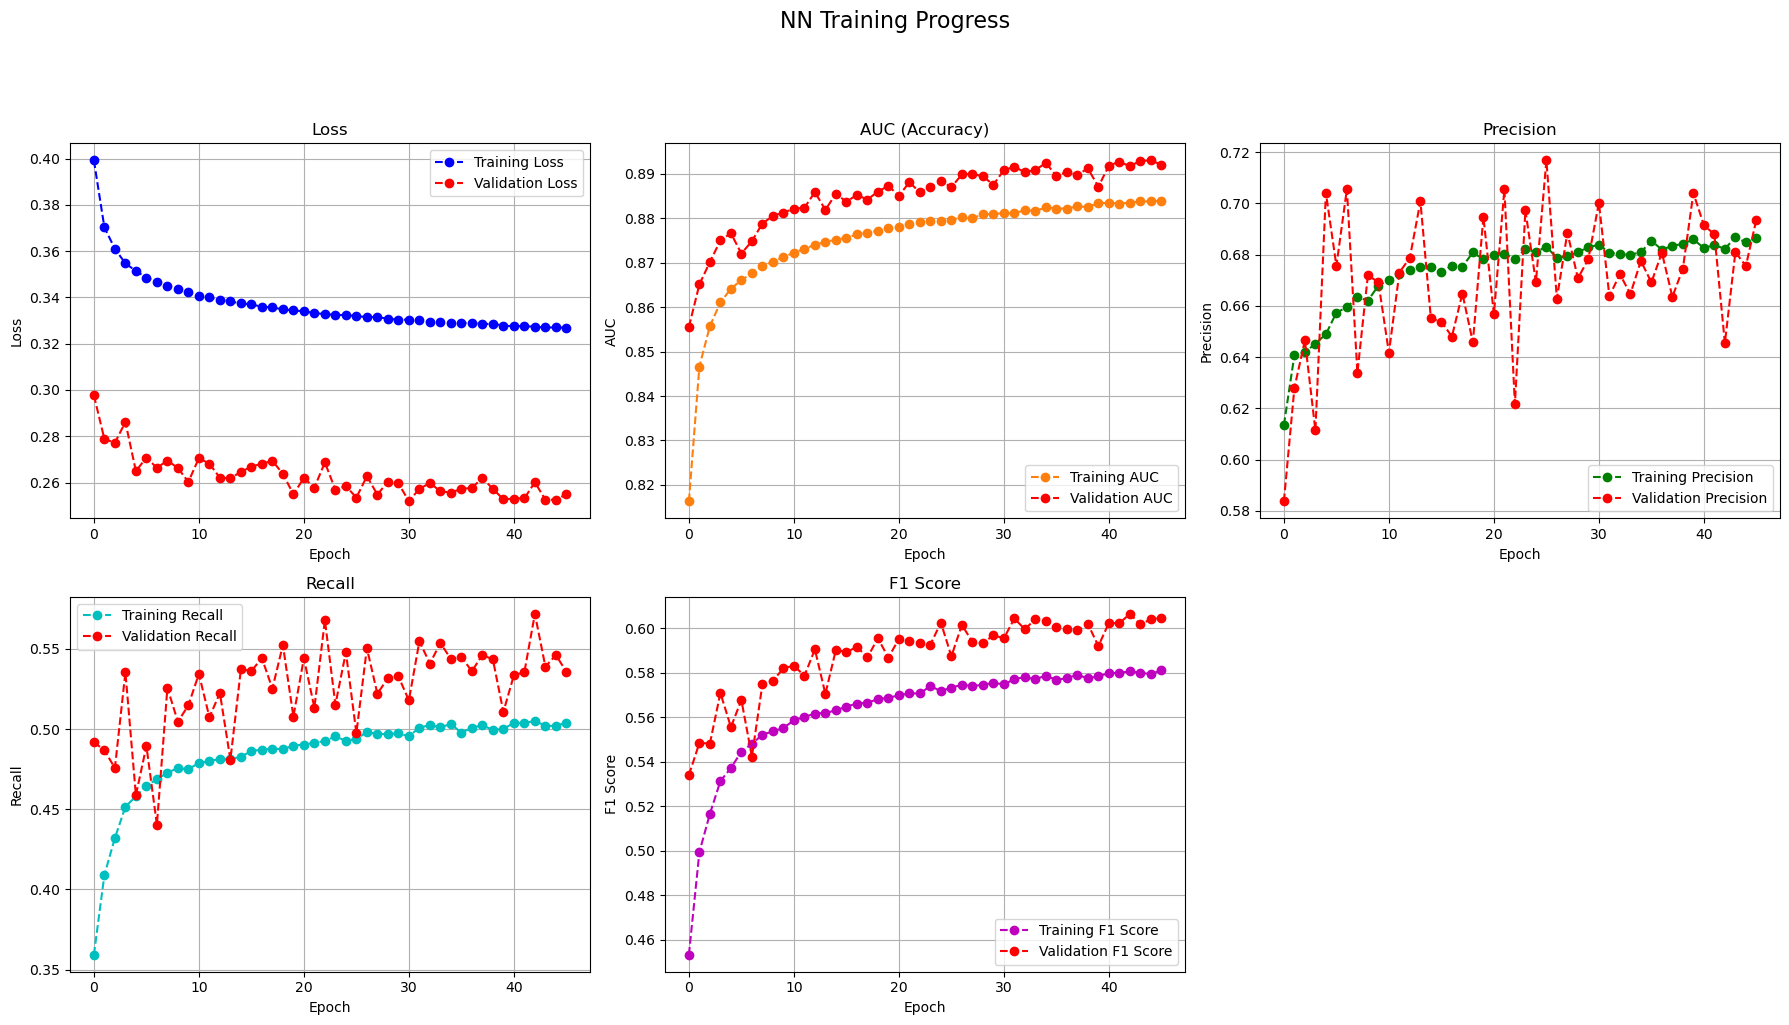

In [12]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_1" in history.history:
        return history.history[f"{metric_name}_1"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score with epsilon to avoid division by zero
epsilon = 1e-10  # small value to prevent division by zero
epoch_f1s = [2 * (p * r) / (p + r + epsilon) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r + epsilon) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Evaluate the model

5920/5920 [==============================] - 8s 1ms/step - loss: 0.2519 - precision: 0.7003 - recall: 0.5179 - auc: 0.8909
Loss =  0.25194427371025085
Accuracy =  0.7002636194229126
5920/5920 [==============================] - 6s 985us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.9259    0.9645    0.9448    163265
   Malicious     0.7003    0.5179    0.5955     26158

    accuracy                         0.9028    189423
   macro avg     0.8131    0.7412    0.7701    189423
weighted avg     0.8947    0.9028    0.8965    189423

False Positive Rate = 0.0355189415980155

Confusion Matrix:
[[157466   5799]
 [ 12610  13548]]


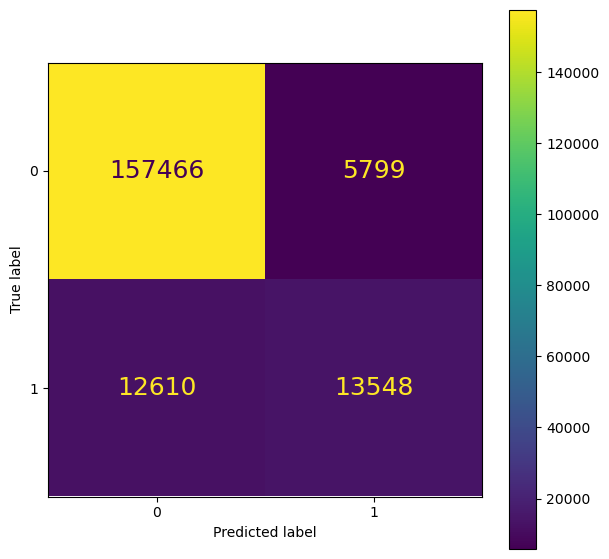

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

# Feature Importance Analysis

In [14]:
analyze_feature_importance = False

if analyze_feature_importance:
    
    import shap
    
    # Ensure that X_train and X_test are DataFrames with the correct column names
    # You can set the column names from the 'features' DataFrame like this:
    X_train.columns = features.columns
    X_test.columns = features.columns
    
    n_samples = 1000
    
    # Convert your training set to a NumPy format if it's not already
    background = X_train[:n_samples].to_numpy()
    
    # Use the generic SHAP Explainer interface
    explainer = shap.Explainer(model, background)
    
    # Generate SHAP values for the test set
    shap_values = explainer(X_test[:n_samples].to_numpy())
    
    # Plotting the summary plot for feature importance
    # Use the column names from the 'features' DataFrame as the feature names
    shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=30)


# Validate the model on a separate Validation dataset

78/78 [==============================] - 0s 1ms/step
Accuracy: 0.9346774193548387
Weighted Accuracy: 0.669653155379799
Precision: 0.5258620689655172
Recall: 0.3630952380952381
F1 Score: 0.42957746478873243
False Positive Rate: 0.02378892733564014


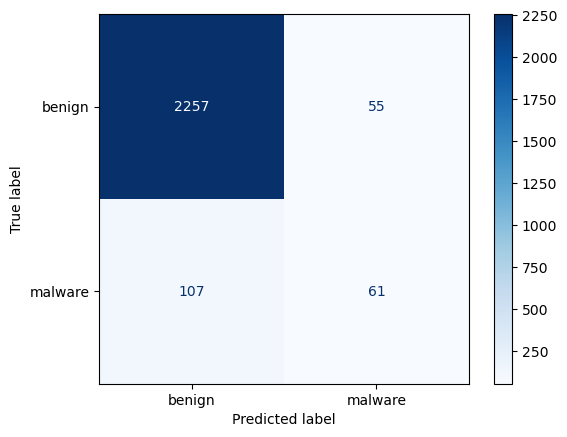

Misclassified domains: ['new1.qawsedrftgyhujik21.shop', 'wwwspolinoff.top', 'wliqui.wmaymon.info', 'aipanda097.cern.ch', 'soamzakyan.info', 'fbc-algo.com', 'osmreview.com', 'c93ec95a80b21090fd7e34e305abcca9.nitwos.pl', 'interskin.cyou', '14e9293657039914b8cd8816f49265c3.btntls.pl', 'cctvmonk.com', 'esx1.qawsedrftgyhujik27.shop', '1ict4apf8oom7qga94n31uwt9.trivialextrovertedarrangement.pro', 'emv1.semanejo.com', 'mostbet-cz.mobi', 'www.pl-podx.com', 'goelancer.com', 'www.csharkapp.com', 'atlas-assets.thoughtindustriesproxy.com', 'www.xn--6fr63ay49i02c.top', 'tel.aptin.live', 'www.nowasytuacja.click', 'pop.lennoxparkandrec.com', 'sprawdzamaml.com', 'session-recvinted.zyrosite.com', 'esx1.hlsvideocdn120.shop', '470e4de926e119f2bc895d1fc88527e7.noktsa.pl', 'streamboox.com', 'atoznewslive.com', 'pas.mtprogram.xyz', '2d5b51746f2a1cd5457029486bda71f6.loftx.pl', 'zzzyyzzzyyyzyyzyyyzzyyzyzzzzzzzzyyzzyyyyyzyzyyzzyzpol7196.cmkaarten.nl', 'c5d1f04b310fffcee5ad5743322729ce.puoli.pl', 'banners5html2

In [15]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from pandas.core.dtypes import common as com
import numpy as np

def cast_timestamp(df: pd.DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)
    return df

# Load the validation dataset
df_validation = pq.read_table(validation_dataset_filename).to_pandas()

# Cast timestamps and handle NaNs
df_validation = cast_timestamp(df_validation)
df_validation.fillna(-1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df_validation.columns:
        df_validation.drop(column, axis=1, inplace=True)

# Preserve only columns of interest
df_validation = df_validation.loc[:, df_validation.columns.str.startswith(prefix) | df_validation.columns.isin(['domain_name', 'label'])]
        
# Map the labels
df_validation['label'] = df_validation['label'].map({benign_label: 0, malicious_label: 1})

# Extract features and labels
X_val = df_validation.drop(['label', 'domain_name'], axis=1)
y_val = df_validation['label']

# Load the scaler
scaler = joblib.load(scaler_path)

# Scale the features
X_val_scaled = scaler.transform(X_val)

# Load the trained model
model = load_model(model_path)

# Make predictions
y_prob = model.predict(X_val_scaled).flatten()
y_pred = (y_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
weighted_accuracy = (accuracy_score(y_val[y_val == 0], y_pred[y_val == 0]) + accuracy_score(y_val[y_val == 1], y_pred[y_val == 1])) / 2
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
false_positive_rate = fp / (fp + tn)

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Weighted Accuracy: {weighted_accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'False Positive Rate: {false_positive_rate}')

# Display confusion matrix
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[benign_label, malicious_label])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Identify misclassified domain names
misclassified = df_validation[y_val != y_pred]
misclassified_domains = misclassified['domain_name'].tolist()
print(f'Misclassified domains: {misclassified_domains}')


# Make test predictions

In [16]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

# Load the model and scaler
model = load_model(model_path)
scaler = joblib.load(scaler_path)

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312_anonymized.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/malware_bp.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
test_df = pd.concat([df_benign, df_malicious])

# Handle NaNs
test_df.fillna(-1, inplace=True)


# Take only N random samples
N = 500
test_df = test_df.sample(n=N, random_state=42)

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    domain_name = row['domain_name']
    original_label = row['label']
    
    # Drop "domain_name" and "label" columns
    feature_vector = pd.DataFrame([row])
    feature_vector.drop(columns=['domain_name', 'label'], inplace=True)

     # Scale the feature vector using the loaded scaler
    scaled_feature_vector = scaler.transform(feature_vector)
    
    # Perform prediction
    prediction = model.predict(scaled_feature_vector, verbose=0)
    
    # Extract the predicted class
    predicted_label = "benign" if prediction < 0.5 else "malware"
    
    # Check if the prediction was correct
    if original_label == predicted_label:
        correct_predictions += 1
    
    total_predictions += 1
    
    # Print the result
    result="WRONG"
    if predicted_label == original_label:
        result="OK"
        
    pred_disp = "!!! MALWARE !!!"
    if predicted_label == "benign":
        pred_disp = "BENIGN"
        
    
    print(f"{result} | {domain_name} ({original_label}), Predicted: {pred_disp}, Prob: {prediction}")

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")




FileNotFoundError: ../feature-extraction/floor/benign_2312_anonymized.parquet